In [291]:
import os
import sys
import numpy as np
import pandas as pd
import pickle
import random
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import hinge_loss
from AEspeech import AEspeech
import pdb
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.svm import SVC
from scipy import stats
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import joblib

In [334]:
"""
Specify rep choice: <'narrowband', 'broadband', 'wvlt', 'early_fuse', 'late_fuse', 'mc_fuse' (multi-channel fusion)>
"""

PATH=os.getcwd()

mod="CAE"
rep='mc_fuse'

if rep in ['narrowband', 'broadband', 'wvlt']:
    trainRes_path=PATH+"/pdSpanish/classResults/dnn/"+mod+'_'+rep+'_aggTrainResults.pkl'
    testRes_path=PATH+"/pdSpanish/classResults/dnn/"+mod+'_'+rep+'_aggTestResults.pkl'
    trainRes=pd.read_pickle(trainRes_path)
    testRes=pd.read_pickle(testRes_path)

if rep=='mc_fuse':
    trMCResultsPath=PATH+"/pdSpanish/classResults/dnn/"+mod+'_mcFusion_trainResults.pkl'
    tstMCResultsPath=PATH+"/pdSpanish/classResults/dnn/"+mod+'_mcFusion_testResults.pkl'
    trainRes=pd.read_pickle(trMCResultsPath)
    testRes=pd.read_pickle(tstMCResultsPath)
    rep='multi-channel fusion - narrowband/broadband'

if rep=='early_fuse':
    trEFResultsPath=PATH+"/pdSpanish/classResults/dnn/"+mod+'_earlyFusion_trainResults.pkl'
    tstEFResultsPath=PATH+"/pdSpanish/classResults/dnn/"+mod+'_earlyFusion_testResults.pkl'
    trainRes=pd.read_pickle(trEFResultsPath)
    testRes=pd.read_pickle(tstEFResultsPath)
    rep='early fusion - narrowband/broadband'

if rep=='late_fuse':
    trLFResultsPath=PATH+"/pdSpanish/classResults/dnn/"+mod+'_lateFusion_trainResults.pkl'
    tstLFResultsPath=PATH+"/pdSpanish/classResults/dnn/"+mod+'_lateFusion_testResults.pkl'
    trainRes=pd.read_pickle(trLFResultsPath)
    testRes=pd.read_pickle(tstLFResultsPath)
    rep='late fusion - narrowband/broadband'

mfda_path=PATH+"/pdSpanish/"
mfdas=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")['M-FDA'].values
pd_mfdas=mfdas[0:50]
hc_mfdas=mfdas[50:]

In [335]:
avgAggResults={spk:{} for spk in ['pd','hc']}
for col in testRes.columns:
    for idx in testRes.index:
        if idx=='tstSpk_data':
            for key in testRes[col][idx].keys():
                if key<50:
                    avgAggResults['pd'][key]=testRes[col][idx][key]
                else:
                    avgAggResults['hc'][key]=testRes[col][idx][key]                                                                                

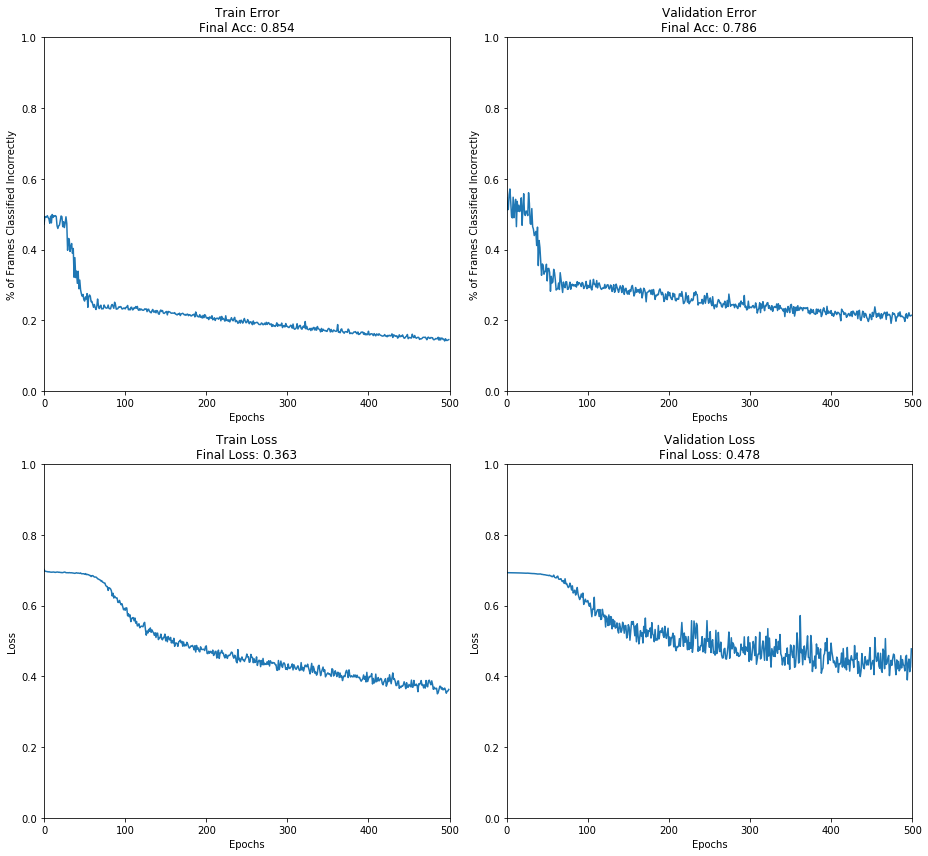

In [336]:
train_acc=0
val_acc=0
train_loss=0
val_loss=0
num_itrs=trainRes.index[-1][0]+1

for i in range(num_itrs):
    train_acc+=trainRes['train_acc'][i]/num_itrs
    val_acc+=trainRes['val_acc'][i]/num_itrs
    train_loss+=trainRes['train_loss'][i]/num_itrs
    val_loss+=trainRes['val_loss'][i]/num_itrs
    
fig,ax=plt.subplots(2,2,figsize=(13, 12))

ax[0][0].plot(1-train_acc)
ax[0][0].set_title("Train Error\nFinal Acc: "+str(np.round(train_acc.iloc[-1],3)))
ax[0][0].set_xlabel("Epochs")
ax[0][0].set_ylabel("% of Frames Classified Incorrectly")
ax[0][0].set_xlim([0,train_acc.size])
ax[0][0].set_ylim([0,1])

ax[0][1].plot(1-val_acc)
ax[0][1].set_title("Validation Error\nFinal Acc: "+str(np.round(val_acc.iloc[-1],3)))
ax[0][1].set_xlabel("Epochs")
ax[0][1].set_ylabel("% of Frames Classified Incorrectly")
ax[0][1].set_xlim([0,train_acc.size])
ax[0][1].set_ylim([0,1])

ax[1][0].plot(train_loss)
ax[1][0].set_title("Train Loss\nFinal Loss: "+str(np.round(train_loss.iloc[-1],3)))
ax[1][0].set_xlabel("Epochs")
ax[1][0].set_ylabel("Loss")
ax[1][0].set_xlim([0,train_acc.size])
ax[1][0].set_ylim([0,1])

ax[1][1].plot(val_loss)
ax[1][1].set_title("Validation Loss\nFinal Loss: "+str(np.round(val_loss.iloc[-1],3)))
ax[1][1].set_xlabel("Epochs")
ax[1][1].set_ylabel("Loss")
ax[1][1].set_xlim([0,train_acc.size])
ax[1][1].set_ylim([0,1])

plt.tight_layout()

In [337]:
y_score=np.zeros((100,2))
y_test=np.zeros((100,2))
thresh=0

for i in range(100):
    if i<50:
        y_score[i,:]=np.median(avgAggResults['pd'][i][:,0]),np.median(avgAggResults['pd'][i][:,1])
        y_test[i,:]=np.vstack((np.zeros(1),np.ones(1))).T
    else:
        y_score[i,:]=np.median(avgAggResults['hc'][i][:,0]),np.median(avgAggResults['hc'][i][:,1])
        y_test[i,:]=np.vstack((np.ones(1),np.zeros(1))).T

        

Text(0.5, 1.0, 'ANN Classifier\n m-FDA v. Difference in Classification Probability\nCAE, multi-channel fusion - narrowband/broadband\nOverall Test Acc: 0.96\n$\\rho$ = 0.735')

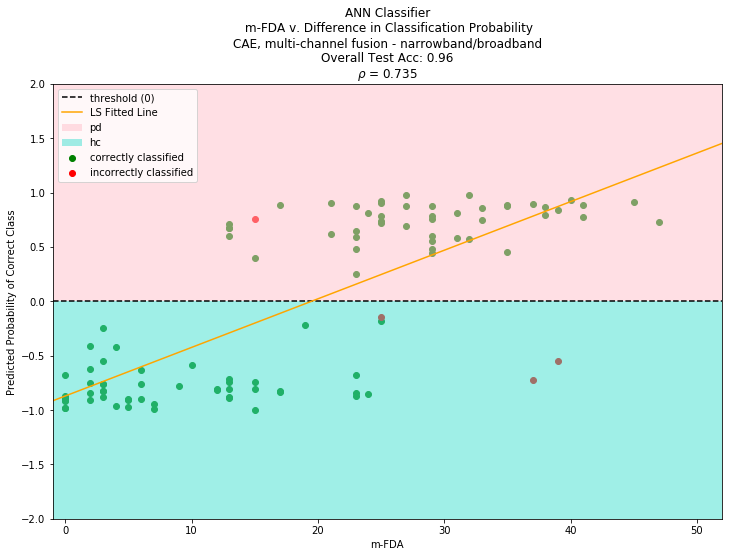

In [338]:
"""Prediction based on difference between predicted class probs."""
poly=np.polyfit(mfdas, y_score[:,1]-y_score[:,0], 1)
x_lin_reg = range(-2, 53)
predict = np.poly1d(poly)
cor=stats.spearmanr(mfdas, y_score[:,1]-y_score[:,0])

plt.figure(figsize=(12,8))
correct_idx=np.concatenate((np.where((y_score[0:50,1]-y_score[0:50,0])>0)[0],np.where((y_score[50:,1]-y_score[50:,0])<0)[0]+50))
incorrect_idx=np.concatenate((np.where((y_score[0:50,1]-y_score[0:50,0])<0)[0],np.where((y_score[50:,1]-y_score[50:,0])>0)[0]+50))
plt.scatter(mfdas[correct_idx],(y_score[:,1]-y_score[:,0])[correct_idx],c='g' )
plt.scatter(mfdas[incorrect_idx],(y_score[:,1]-y_score[:,0])[incorrect_idx],c='r' )
plt.axhline(y=thresh, color='black', linestyle='--',label="optimal threshold")
plt.plot(x_lin_reg,predict(x_lin_reg), color='orange')
plt.axhspan(thresh, 2, color='pink', alpha=0.5, lw=0)
plt.axhspan(-2, thresh, color='turquoise', alpha=0.5, lw=0)
plt.legend(['threshold ('+str(thresh)+')','LS Fitted Line', 'pd', 'hc', 'correctly classified', 'incorrectly classified'])
plt.xlim([-1,52])
plt.ylim([-2,2])
plt.xlabel('m-FDA')
plt.ylabel('Predicted Probability of Correct Class')
plt.title('ANN Classifier\n m-FDA v. Difference in Classification Probability\n'+mod+", "+rep+'\nOverall Test Acc: '+str(correct_idx.shape[0]/100)+'\n'+r'$\rho$'+ " = "+str(np.round(cor[0],3)))


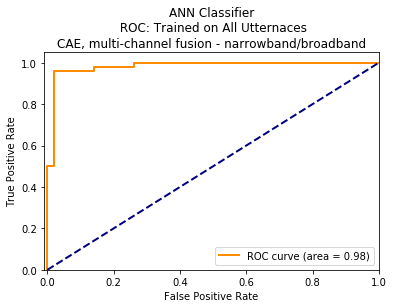

In [339]:
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test[:, i]), np.array(y_score[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
mgc=1
plt.plot(fpr[mgc], tpr[mgc], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ANN Classifier\n ROC: Trained on All Utternaces\n'+mod+", "+rep)
plt.legend(loc="lower right")

Text(0.5, 1.0, 'ANN Classifier\nm-FDA v. Difference in Classification Probability for 20th percentile "extreme" cases\n(m-FDAs <= 2 and >= 37)\nCAE, multi-channel fusion - narrowband/broadband\nOverall Test Acc: 0.9\n$\\rho$ = 0.846')

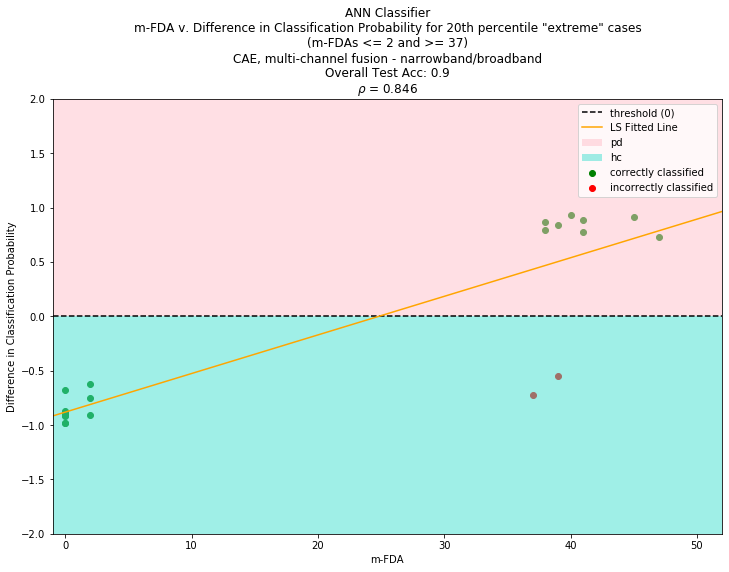

In [340]:
"""Looking at 2*n most 'extreme' cases in the database (n patients with smallest and n patients with largest m-fdas)"""

n=10

df=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")
tail10_idx=np.sort(np.concatenate((df.nsmallest(n,['M-FDA']).index,df.nlargest(n,['M-FDA']).index)))
max_low=max(list(df['M-FDA'].nsmallest(n)))
min_high=min(list(df['M-FDA'].nlargest(n)))
xtr_mfdas=mfdas[tail10_idx]
xtr_y_score=y_score[tail10_idx,:]
xtr_y_test=y_test[tail10_idx,:]


"""Prediction based on difference between predicted class probs."""
plt.figure(figsize=(12,8))
poly=np.polyfit(xtr_mfdas, xtr_y_score[:,1]-xtr_y_score[:,0], 1)
x_lin_reg = range(-2, 53)
predict = np.poly1d(poly)
cor=stats.spearmanr(xtr_mfdas, xtr_y_score[:,1]-xtr_y_score[:,0])

correct_idx=np.concatenate((np.where((xtr_y_score[0:n,1]-xtr_y_score[0:n,0])>0)[0],np.where((xtr_y_score[n:,1]-xtr_y_score[n:,0])<0)[0]+n))
incorrect_idx=np.concatenate((np.where((xtr_y_score[0:n,1]-xtr_y_score[0:n,0])<0)[0],np.where((xtr_y_score[n:,1]-xtr_y_score[n:,0])>0)[0]+n))
plt.scatter(xtr_mfdas[correct_idx],(xtr_y_score[:,1]-xtr_y_score[:,0])[correct_idx],c='g' )
plt.scatter(xtr_mfdas[incorrect_idx],(xtr_y_score[:,1]-xtr_y_score[:,0])[incorrect_idx],c='r' )
plt.axhline(y=thresh, color='black', linestyle='--',label="optimal threshold")
plt.plot(x_lin_reg,predict(x_lin_reg), color='orange')
plt.axhspan(thresh, 2, color='pink', alpha=0.5, lw=0)
plt.axhspan(-2, thresh, color='turquoise', alpha=0.5, lw=0)
plt.legend(['threshold ('+str(thresh)+')','LS Fitted Line', 'pd', 'hc', 'correctly classified', 'incorrectly classified'])
plt.xlim([-1,52])
plt.ylim([-2,2])
plt.xlabel('m-FDA')
plt.ylabel('Difference in Classification Probability')
plt.title('ANN Classifier\nm-FDA v. Difference in Classification Probability for '+str(2*n)+'th percentile "extreme" cases\n(m-FDAs <= '+str(max_low)+' and >= '+str(min_high)+')\n'+mod+", "+rep+'\nOverall Test Acc: '+str(correct_idx.shape[0]/(2*n))+'\n'+r'$\rho$'+ " = "+str(np.round(cor[0],3)))



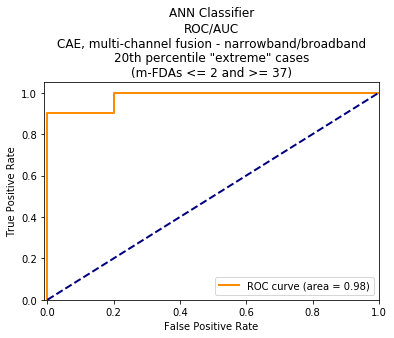

In [341]:
"""
Looking at the ROC for a given classifier for a given patient and corresponding AUC.
Specifically, looking at 2*n most 'extreme' cases in the database (n patients with smallest and n patients with largest m-fdas)

"""
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(xtr_y_test[:, i]), np.array(xtr_y_score[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
mgc=1
plt.plot(fpr[mgc], tpr[mgc], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ANN Classifier\nROC/AUC\n'+mod+", "+rep+'\n'+str(2*n)+'th percentile "extreme" cases\n(m-FDAs <= '+str(max_low)+' and >= '+str(min_high)+')')
plt.legend(loc="lower right")

Text(0.5, 1.0, 'ANN Classifier\nm-FDA v. Difference in Classification Probability for Middle 80th Percentile of m-FDAs\n(m-FDAs >= 2 and <= 37)\nCAE, multi-channel fusion - narrowband/broadband\nOverall Test Acc: 0.975\n$\\rho$ = 0.686')

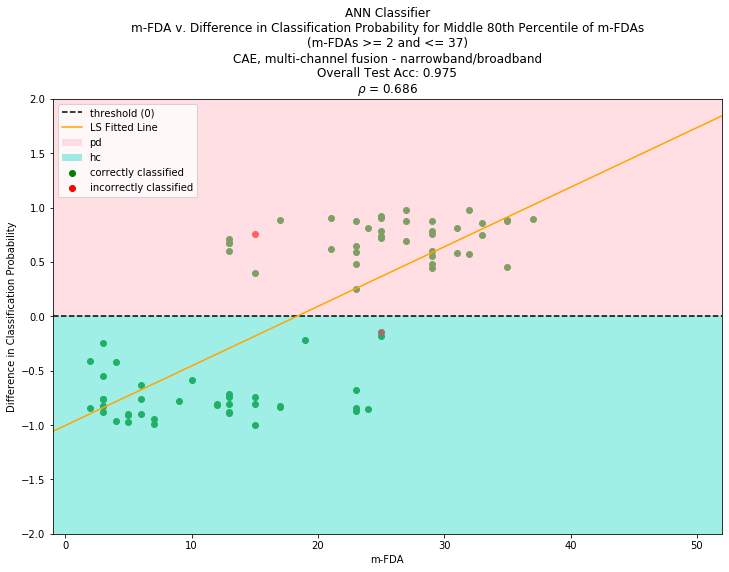

In [342]:
"""Looking at results for spks corresponding to middle num_spks-2*n m-FDAs."""

n=10

df=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")
tail10_idx=np.sort(np.concatenate((df.nsmallest(n,['M-FDA']).index,df.nlargest(n,['M-FDA']).index)))
mid_idxs=np.array([idx for idx in np.arange(100) if idx not in tail10_idx])
max_low=max(list(df['M-FDA'].nsmallest(n)))
min_high=min(list(df['M-FDA'].nlargest(n)))
mid_mfdas=mfdas[mid_idxs]
mid_y_score=y_score[mid_idxs,:]
mid_y_test=y_test[mid_idxs,:]


"""Prediction based on difference between predicted class probs."""
plt.figure(figsize=(12,8))
poly=np.polyfit(mid_mfdas, mid_y_score[:,1]-mid_y_score[:,0], 1)
x_lin_reg = range(-2, 53)
predict = np.poly1d(poly)
cor=stats.spearmanr(mid_mfdas, mid_y_score[:,1]-mid_y_score[:,0])

correct_idx=np.concatenate((np.where((mid_y_score[0:40,1]-mid_y_score[0:40,0])>0)[0],np.where((mid_y_score[40:,1]-mid_y_score[40:,0])<0)[0]+40))
incorrect_idx=np.concatenate((np.where((mid_y_score[0:40,1]-mid_y_score[0:40,0])<0)[0],np.where((mid_y_score[40:,1]-mid_y_score[40:,0])>0)[0]+40))
plt.scatter(mid_mfdas[correct_idx],(mid_y_score[:,1]-mid_y_score[:,0])[correct_idx],c='g' )
plt.scatter(mid_mfdas[incorrect_idx],(mid_y_score[:,1]-mid_y_score[:,0])[incorrect_idx],c='r' )
plt.axhline(y=thresh, color='black', linestyle='--',label="optimal threshold")
plt.plot(x_lin_reg,predict(x_lin_reg), color='orange')
plt.axhspan(thresh, 2, color='pink', alpha=0.5, lw=0)
plt.axhspan(-2, thresh, color='turquoise', alpha=0.5, lw=0)
plt.legend(['threshold ('+str(thresh)+')','LS Fitted Line', 'pd', 'hc', 'correctly classified', 'incorrectly classified'])
plt.xlim([-1,52])
plt.ylim([-2,2])
plt.xlabel('m-FDA')
plt.ylabel('Difference in Classification Probability')
plt.title('ANN Classifier\nm-FDA v. Difference in Classification Probability for Middle '+str(100-2*n)+'th Percentile of m-FDAs\n(m-FDAs >= '+str(max_low)+' and <= '+str(min_high)+')\n'+mod+", "+rep+'\nOverall Test Acc: '+str(correct_idx.shape[0]/(100-2*n))+'\n'+r'$\rho$'+ " = "+str(np.round(cor[0],3)))

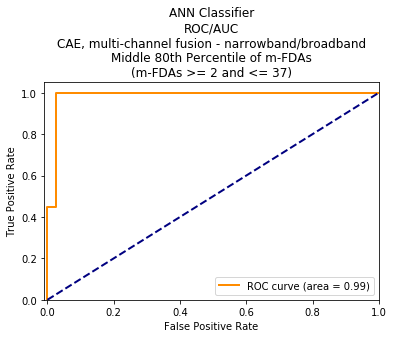

In [343]:
"""
Looking at the ROC for a given classifier for a given patient and corresponding AUC.
Specifically, looking at spks corresponding to middle num_spks-2*n m-FDAs.

"""
fpr=dict()
tpr=dict()
roc_auc=dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(np.array(mid_y_test[:, i]), np.array(mid_y_score[:, i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
mgc=1
plt.plot(fpr[mgc], tpr[mgc], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[mgc])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ANN Classifier\nROC/AUC\n'+mod+", "+rep+'\nMiddle '+str(100-2*n)+'th Percentile of m-FDAs\n(m-FDAs >= '+str(max_low)+' and <= '+str(min_high)+')')
plt.legend(loc="lower right")

One sided T-test to determine if difference in M/F results is significant.
Null Hypothesis: mean difference in probability output by the classifier for M/F speakers
 is not significant.

M/F actual m-FDAS [T-test stat: 0.627 p-value: 0.532]
M/F difference in probabilities [T-test stat: 0.28599 p-value: 0.77549]


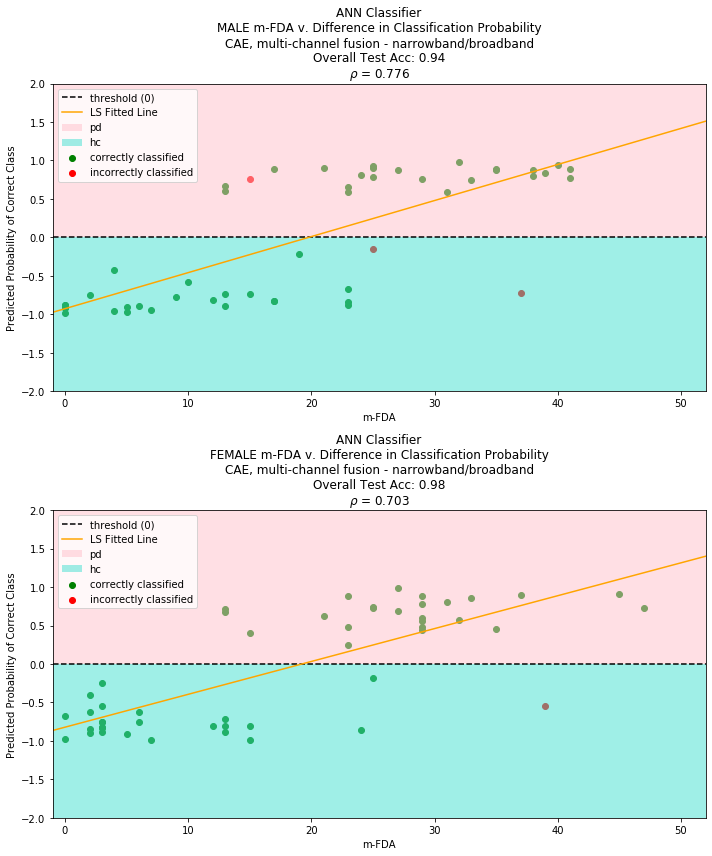

In [344]:
"""Gender based classification results (note that data used to train AEs skewed heavily male while PD data is evenly split M/F)"""
num_spks=100
mfda_path=PATH+"/pdSpanish/"
data=pd.read_csv(mfda_path+"metadata-Spanish_All.csv")
genders=data['gender'].values
mfdas=data['M-FDA'].values
m_idx=np.where(genders=='M')[0]
f_idx=np.where(genders=='F')[0]
m_mfdas=mfdas[m_idx]
f_mfdas=mfdas[f_idx]

m_test_acc=0
f_test_acc=0
m_y_score=np.zeros((50,2))
m_y_test=np.zeros((50,2))
f_y_score=np.zeros((50,2))
f_y_test=np.zeros((50,2))

m_count=0
f_count=0
for i in range(100):
    if i<50:
        if i in m_idx:
            m_y_score[m_count,:]=np.median(avgAggResults['pd'][i][:,0]),np.median(avgAggResults['pd'][i][:,1])
            m_y_test[m_count,:]=np.vstack((np.zeros(1),np.ones(1))).T
            spk_diff=m_y_score[m_count,1]-m_y_score[m_count,0]
            if spk_diff>thresh:
                m_test_acc+=1
            m_count+=1
        elif i in f_idx:
            f_y_score[f_count,:]=np.median(avgAggResults['pd'][i][:,0]),np.median(avgAggResults['pd'][i][:,1])
            f_y_test[f_count,:]=np.vstack((np.zeros(1),np.ones(1))).T
            spk_diff=f_y_score[f_count,1]-f_y_score[f_count,0]
            if spk_diff>thresh:
                f_test_acc+=1
            f_count+=1
    else:
        if i in m_idx:
            m_y_score[m_count,:]=np.median(avgAggResults['hc'][i][:,0]),np.median(avgAggResults['hc'][i][:,1])
            m_y_test[m_count,:]=np.vstack((np.ones(1),np.zeros(1))).T
            spk_diff=m_y_score[m_count,1]-m_y_score[m_count,0]
            if spk_diff<thresh:
                m_test_acc+=1
            m_count+=1
        elif i in f_idx:
            f_y_score[f_count,:]=np.median(avgAggResults['hc'][i][:,0]),np.median(avgAggResults['hc'][i][:,1])
            f_y_test[f_count,:]=np.vstack((np.ones(1),np.zeros(1))).T
            spk_diff=f_y_score[f_count,1]-f_y_score[f_count,0]
            if spk_diff<thresh:
                f_test_acc+=1
            f_count+=1


"""Prediction based on difference between predicted class probs."""
itr=0


print('One sided T-test to determine if difference in M/F results'+
      ' is significant.\nNull Hypothesis: mean difference in probability output by the classifier for M/F speakers'+
      '\n is not significant.\n\nM/F actual m-FDAS [T-test stat: '+
      str(np.round(np.abs(stats.ttest_ind(m_mfdas,f_mfdas).statistic),3))+
      ' p-value: '+str(np.round(np.abs(stats.ttest_ind(m_mfdas,f_mfdas).pvalue),3))+
      ']\nM/F difference in probabilities [T-test stat: '+
      str(np.round(np.abs(stats.ttest_ind(m_y_score[:,0],f_y_score[:,0]).statistic),5))+
      ' p-value: '+str(np.round(np.abs(stats.ttest_ind(m_y_score[:,0],f_y_score[:,0]).pvalue),5))+']')

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,12))
for ax,mfdas,y_score,y_test in zip([ax1,ax2],[m_mfdas,f_mfdas],[m_y_score,f_y_score],[m_y_test,f_y_test]):
    poly=np.polyfit(mfdas, y_score[:,1]-y_score[:,0], 1)
    x_lin_reg = range(-2, 53)
    predict = np.poly1d(poly)
    cor=stats.spearmanr(mfdas, y_score[:,1]-y_score[:,0])
    
    correct_idx=np.concatenate((np.where((y_score[0:25,1]-y_score[0:25,0])>0)[0],np.where((y_score[25:,1]-y_score[25:,0])<0)[0]+25))
    incorrect_idx=np.concatenate((np.where((y_score[0:25,1]-y_score[0:25,0])<0)[0],np.where((y_score[25:,1]-y_score[25:,0])>0)[0]+25))
    ax.scatter(mfdas[correct_idx],(y_score[:,1]-y_score[:,0])[correct_idx],c='g' )
    ax.scatter(mfdas[incorrect_idx],(y_score[:,1]-y_score[:,0])[incorrect_idx],c='r' )
    ax.axhline(y=thresh, color='black', linestyle='--',label="optimal threshold")
    ax.plot(x_lin_reg,predict(x_lin_reg), color='orange')
    ax.axhspan(thresh, 2, color='pink', alpha=0.5, lw=0)
    ax.axhspan(-2, thresh, color='turquoise', alpha=0.5, lw=0)
    ax.legend(['threshold ('+str(thresh)+')','LS Fitted Line', 'pd', 'hc', 'correctly classified', 'incorrectly classified'],fontsize=12)
    ax.set_xlim([-1,52])
    ax.set_ylim([-2,2])
    ax.set_xlabel('m-FDA',fontsize=12)
    ax.set_ylabel('Predicted Probability of Correct Class',fontsize=12)
    if itr==0:
        ax.set_title('ANN Classifier\nMALE m-FDA v. Difference in Classification Probability\n'+mod+", "+rep+'\nOverall Test Acc: '+str(correct_idx.shape[0]/50)+'\n'+r'$\rho$'+ " = "+str(np.round(cor[0],3)), fontsize=16)
        itr+=1
    else:
        ax.set_title('ANN Classifier\nFEMALE m-FDA v. Difference in Classification Probability\n'+mod+", "+rep+'\nOverall Test Acc: '+str(correct_idx.shape[0]/50)+'\n'+r'$\rho$'+ " = "+str(np.round(cor[0],3)), fontsize=16)
plt.tight_layout()